### **09. 회귀 실습 - 자전거 대여 수요 예측**

#### **a. 데이터 클렌징 및 가공**
  - 피처 데이터
    - datetime : hourly date + timestamp
    - season : 1=봄, 2=여름, 3=가을, 4=겨울
    - holiday : 1=주말을 제외한 휴일, 0=휴일이 아닌날
    - workingday : 1=주말 및 휴일이 아닌 주중, 0=주말 및 휴일
    - weather : 1=맑음, 약간 구름 낀 흐림, 2=안개, 안개+흐림, 3=가벼운 눈, 가벼운 비+천둥, 4=심한 눈/비, 천둥/번개
    - temp: 온도
    - atemp: 체감온도
    - humidity : 상대습도
    - windspeed : 풍속
    - casual : 사전에 등록되지 않은 사용자가 대여한 횟수
    - registered : 사전에 등록된 사용자가 대여한 횟수
  
  - 레이블 데이터
    - count : 대여 횟수

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)

bike_df = pd.read_csv('bike_train.csv')
print(bike_df.shape)
bike_df.head()

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


- 해당 데이터는 10886개의 레코드와 12개의 칼럼으로 구성되어 있다.

In [2]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


- Null 값은 없으며, dataetime 칼럼을 제외한 나머지는 전부 숫자형이다. 

> datetime 타입으로 변환하는 apply(pd.to_dataetime) 메서드를 이용해 년, 월, 일, 시간 칼럼을 추출해보자.

In [3]:
# 문자열을 datetime 타입으로 변경
bike_df['datetime'] = bike_df.datetime.apply(pd.to_datetime)

# datetime 타입에서 년, 월, 일, 시간 추출
bike_df['year'] = bike_df.datetime.apply(lambda x : x.year)
bike_df['month'] = bike_df.datetime.apply(lambda x : x.month)
bike_df['day'] = bike_df.datetime.apply(lambda x : x.day)
bike_df['hour'] = bike_df.datetime.apply(lambda x : x.hour)
bike_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4


- year, month, day, hour 칼럼이 추가되었다.

> 이제 datetime 칼럼은 삭제하고, casual과 registered를 합하면 count이므로 두 칼럼을 삭제한다. (두 칼럼은 상관도가 높아 예측을 저해할 우려가 있으므로 여러모로 삭제하는 것이 좋다.)

In [4]:
drop_columns = ['datetime', 'casual', 'registered']
bike_df.drop(drop_columns, axis = 1, inplace = True)

> 다음으로 다양한 회귀 모델을 데이터 세트에 적용해 예측 성능을 측정해보자. 캐글에서 요구한 RMSLE(Root Mean Square Log Error)를 수행하는 성능 평가 함수를 직접 만들어보자.

In [5]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# log 값 변환 시 NaN 등의 이슈로 log()가 아닌 log1p()를 이용해 RMSLE 계산
def rmsle(y, pred):
  log_y = np.log1p(y)
  log_pred = np.log1p(pred)
  squared_error = (log_y - log_pred) ** 2
  rmsle = np.sqrt(np.mean(squared_error))
  return rmsle

# 사이킷런의 mean_squared_error()를 이용해 RMSE 계산
def rmse(y, pred):
  return np.sqrt(mean_squared_error(y, pred))

# MSE, RMSE, RMSLE를 모두 계산
def evaluate_regr(y, pred):
  rmsle_val = rmsle(y, pred)
  rmse_val = rmse(y, pred)
  # MAE는 사이킷런의 mean_absolute_error()로 계산
  mae_val = mean_absolute_error(y, pred)
  print('RMSLE: {0:.3f}, RMSE: {1:.3f}, MAE: {2:.3f}'.format(rmsle_val, rmse_val, mae_val))

#### **b. 로그 변환, 피처 인코딩과 모델 학습/예측/평가**

> 이제 회귀 모델을 이용해 자전거 대여 횟수를 예측해보자. 그 전에 결과값이 정규 분포로 되어 있는지 확인하고, 범주형 회귀 변수를 원-핫 인코딩하는 단계를 거친다.

In [6]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

y_target = bike_df['count']
X_features = bike_df.drop(['count'], axis = 1, inplace = False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size = 0.3, random_state = 0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

evaluate_regr(y_test, pred)

RMSLE: 1.165, RMSE: 140.900, MAE: 105.924


- 위의 숫자들은 실제 Target 데이터 값인 count를 감안하면, 예측 오류로서는 비교적 큰 값이다.

> 실제값과 예측값이 어느 정도 차이나는지 DataFrame 칼럼으로 만들어서 오류 값이 가장 큰 순으로 5개만 확인해보자.

In [7]:
def get_top_error_data(y_test, pred, n_tops = 5):
  # DataFrame의 칼럼으로 실제 대여 횟수(count)와 예측값을 서로 비교할 수 있도록 생성
  result_df = pd.DataFrame(y_test.values, columns = ['real_count'])
  result_df['predicted_count'] = np.round(pred)
  result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted_count'])

  # 예측값과 실제값이 가장 큰 데이터 순으로 출력
  print(result_df.sort_values('diff', ascending = False)[:n_tops])

get_top_error_data(y_test, pred, n_tops = 5)

      real_count  predicted_count   diff
1618         890            322.0  568.0
3151         798            241.0  557.0
966          884            327.0  557.0
412          745            194.0  551.0
2817         856            310.0  546.0


- 상위 오류 값은 546~568로 실제값을 감안하면 예측 오류가 꽤 크다.

> 보통 이런 경우 타겟 값의 분포가 왜곡된 경우가 많으므로, 레이블 데이터의 분포를 확인해보자.

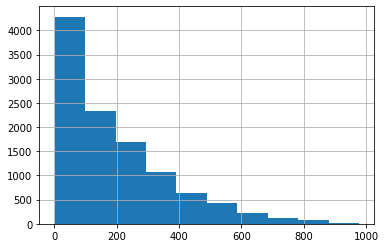

In [8]:
y_target.hist()

- count 칼럼이 정규 분포가 아닌 0~200사이에 왜곡되어 있는 것을 알 수 있다. 

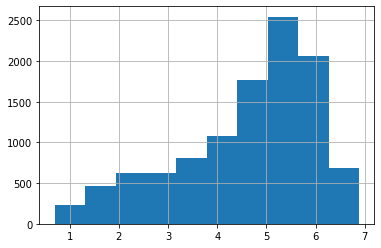

In [9]:
y_log_transform = np.log1p(y_target)
y_log_transform.hist()

- 변환하기 전에 비해 왜곡 정도가 많이 향상되었다.

In [10]:
# 타겟 칼럼인 count 값을 log1p로 로그 변환
y_target_log = np.log1p(y_target)

# 로그 변환된 y_target_log를 반영하여 학습/테스트 데이터 세트 분할
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size=0.3, random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

# 테스트 데이터 세트의 Target 값은 로그 변환되었으므로 다시 expm1()를 이용하여 원래 스케일로 변환
y_test_exp = np.expm1(y_test)

# 예측값 역시 로그 변환된 타겟 기반으로 학습되어 예측됐으므로 다시 expm1()로 스케일 변환
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp, pred_exp)

RMSLE: 1.017, RMSE: 162.594, MAE: 109.286


- RMSLE 오류는 줄어들었지만, RMSE는 오히려 더 늘어났다.

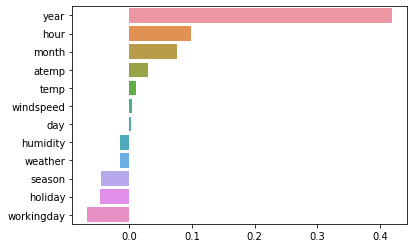

In [11]:
coef = pd.Series(lr_reg.coef_, index = X_features.columns)
coef_sort = coef.sort_values(ascending = False)
sns.barplot(x = coef_sort.values, y = coef_sort.index)

- Year 피처의 회귀 계수 값이 독보적으로 큰 값을 갖는다. 사이킷런은 카테고리만을 위한 데이터 타입이 없으며, 모두 숫자로 변환해야 한다. 하지만 이처럼 숫자형 카테고리 값을 선형 회귀에 적용할 경우, 회귀 계수를 연산할 때 이 숫자형 값에 크게 영향을 받는 경우가 발생할 수 있다. 따라서 선형 회귀에서는 이러한 피처 인코딩에 원-핫 인코딩을 적용해 변환해야 한다.

In [12]:
# 'year', 'month', 'day', 'hour' 등의 피처를 One-Hot Encoding
X_features_ohe = pd.get_dummies(X_features, columns = ['year', 'month', 'day', 'hour', 'holiday', 'workingday', 'season', 'weather'])

> LinearRegression, Ridge, Lasso를 모두 학습해 예측 성능을 확인해보자.

In [13]:
# 원-핫 인코딩이 적용된 피처 데이터 세트를 기반으로 학습/예측 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target_log, test_size = 0.3, random_state = 0)

# 모델과 학습/테스트 데이터 세트를 입력하면 성능 평가 수치를 반환
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1 = False):
  model.fit(X_train, y_train)
  pred = model.predict(X_test)
  if is_expm1:
    y_test = np.expm1(y_test)
    pred = np.expm1(pred)
  print('###', model.__class__.__name__, '###')
  evaluate_regr(y_test, pred)

# 모델별로 평가 수행
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha = 10)
lasso_reg = Lasso(alpha = 0.01)

for model in [lr_reg, ridge_reg, lasso_reg]:
  get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1 = True)

### LinearRegression ###
RMSLE: 0.590, RMSE: 97.688, MAE: 63.382
### Ridge ###
RMSLE: 0.590, RMSE: 98.529, MAE: 63.893
### Lasso ###
RMSLE: 0.635, RMSE: 113.219, MAE: 72.803


- 원-핫 인코딩을 적용하고 나서 선형 회귀의 예측 성능이 많이 향상되었다.

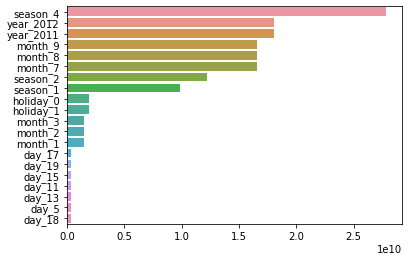

In [14]:
coef = pd.Series(lr_reg.coef_, index = X_features_ohe.columns)
coef_sort = coef.sort_values(ascending = False)[:20]
sns.barplot(x = coef_sort.values, y = coef_sort.index)

> 이번에는 회귀 트리를 이용해 회귀 예측을 수행해보자. 랜덤 포레스트, GBM, XGBoost, LightGBM을 순차적으로 적용해 성능을 평가해보자.

In [15]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 랜덤 포레스트, GBM, XGBoost, LightGBM model 별로 평가 수행
rf_reg = RandomForestRegressor(n_estimators = 500)
gbm_reg = GradientBoostingRegressor(n_estimators = 500)
xgb_reg = XGBRegressor(n_estimators = 500)
lgbm_reg = LGBMRegressor(n_estimators = 500)

for model in [rf_reg, gbm_reg, xgb_reg, lgbm_reg]:
  # XGBoost의 경우 DataFrame이 입력될 경우 버전에 따라 오류 발생 가능, ndarray로 변환
  get_model_predict(model, X_train.values, X_test.values, y_train.values, y_test.values, is_expm1 = True)

### RandomForestRegressor ###
RMSLE: 0.354, RMSE: 50.043, MAE: 31.014
### GradientBoostingRegressor ###
RMSLE: 0.330, RMSE: 53.319, MAE: 32.737
[05:14:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
### XGBRegressor ###
RMSLE: 0.345, RMSE: 58.245, MAE: 35.768
### LGBMRegressor ###
RMSLE: 0.319, RMSE: 47.215, MAE: 29.029


---

### **10. 회귀 실습 - 캐글 주택 가격: 고급 회귀 기법**

#### a. **데이터 사전 처리 (Preprocessing)**

In [17]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

house_df_org = pd.read_csv('house_price.csv')
house_df = house_df_org.copy()
house_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [18]:
print('데이터 세트의 Shape:', house_df.shape)
print('\n전체 feature 들의 type \n', house_df.dtypes.value_counts())
isnull_series = house_df.isnull().sum()
print('\nNull 컬럼과 그 건수:\n', isnull_series[isnull_series > 0].sort_values(ascending = False))

데이터 세트의 Shape: (1460, 81)

전체 feature 들의 type 
 object     43
int64      35
float64     3
dtype: int64

Null 컬럼과 그 건수:
 PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64


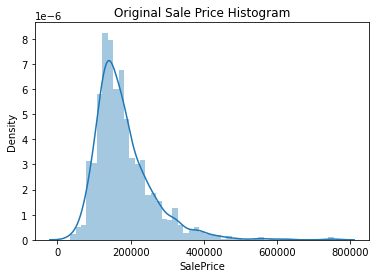

In [19]:
plt.title('Original Sale Price Histogram')
sns.distplot(house_df['SalePrice'])

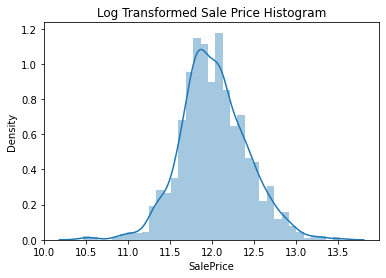

In [20]:
plt.title('Log Transformed Sale Price Histogram')
log_SalePrice = np.log1p(house_df['SalePrice'])
sns.distplot(log_SalePrice)

In [21]:
# SalePrice 로그 변환
original_SalePrice = house_df['SalePrice']
house_df['SalePrice'] = np.log1p(house_df['SalePrice'])

# Null이 너무 많은 칼럼들과 불필요한 칼럼 삭제
house_df.drop(['Id', 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], axis = 1, inplace = True)
# Drop 하지 않는 숫자형 Null 칼럼들은 평균값으로 대체
house_df.fillna(house_df.mean(), inplace = True)

# Null 값이 있는 피처명과 타입을 추출
null_column_count = house_df.isnull().sum()[house_df.isnull().sum() > 0]
print('## Null 피처의 Type:\n', house_df.dtypes[null_column_count.index])

## Null 피처의 Type:
 MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object


In [22]:
print('get_dummies() 수행 전 데이터 Shape:', house_df.shape)
house_df_ohe = pd.get_dummies(house_df)
print('get_dummies() 수행 후 데이터 Shape:', house_df_ohe.shape)

null_column_count = house_df_ohe.isnull().sum()[house_df_ohe.isnull().sum() > 0]
print('## Null 피처의 Type:\n', house_df_ohe.dtypes[null_column_count.index])

get_dummies() 수행 전 데이터 Shape: (1460, 75)
get_dummies() 수행 후 데이터 Shape: (1460, 271)
## Null 피처의 Type:
 Series([], dtype: object)


#### **b. 선형 회귀 모델의 학습/예측/평가**

In [23]:
def get_rmse(model):
  pred = model.predict(X_test)
  mse = mean_squared_error(y_test, pred)
  rmse = np.sqrt(mse)
  print('{0} 로그 변환된 RMSE: {1}'.format(model.__class__.__name__, np.round(rmse, 3)))
  return rmse

def get_rmses(models):
  rmses = []
  for model in models:
    rmse = get_rmse(model)
    rmses.append(rmse)
  return rmses

In [24]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis = 1, inplace = False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size = 0.2, random_state = 156)

# LinearRegression, Ridge, Lasso 학습/예측/평가
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)

lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

LinearRegression 로그 변환된 RMSE: 0.132
Ridge 로그 변환된 RMSE: 0.128
Lasso 로그 변환된 RMSE: 0.176


[0.13189576579154202, 0.12750846334052995, 0.17628250556471403]

In [25]:
def get_top_bottom_coef(model):
  # coef_ 속성을 기반으로 Series 객체를 생성, index는 칼럼명
  coef = pd.Series(model.coef_, index = X_features.columns)

  # + 상위 10개, - 하위 10개 coefficient 추출하여 반환
  coef_high = coef.sort_values(ascending = False).head(10)
  coef_low = coef.sort_values(ascending = False).tail(10)
  return coef_high, coef_low

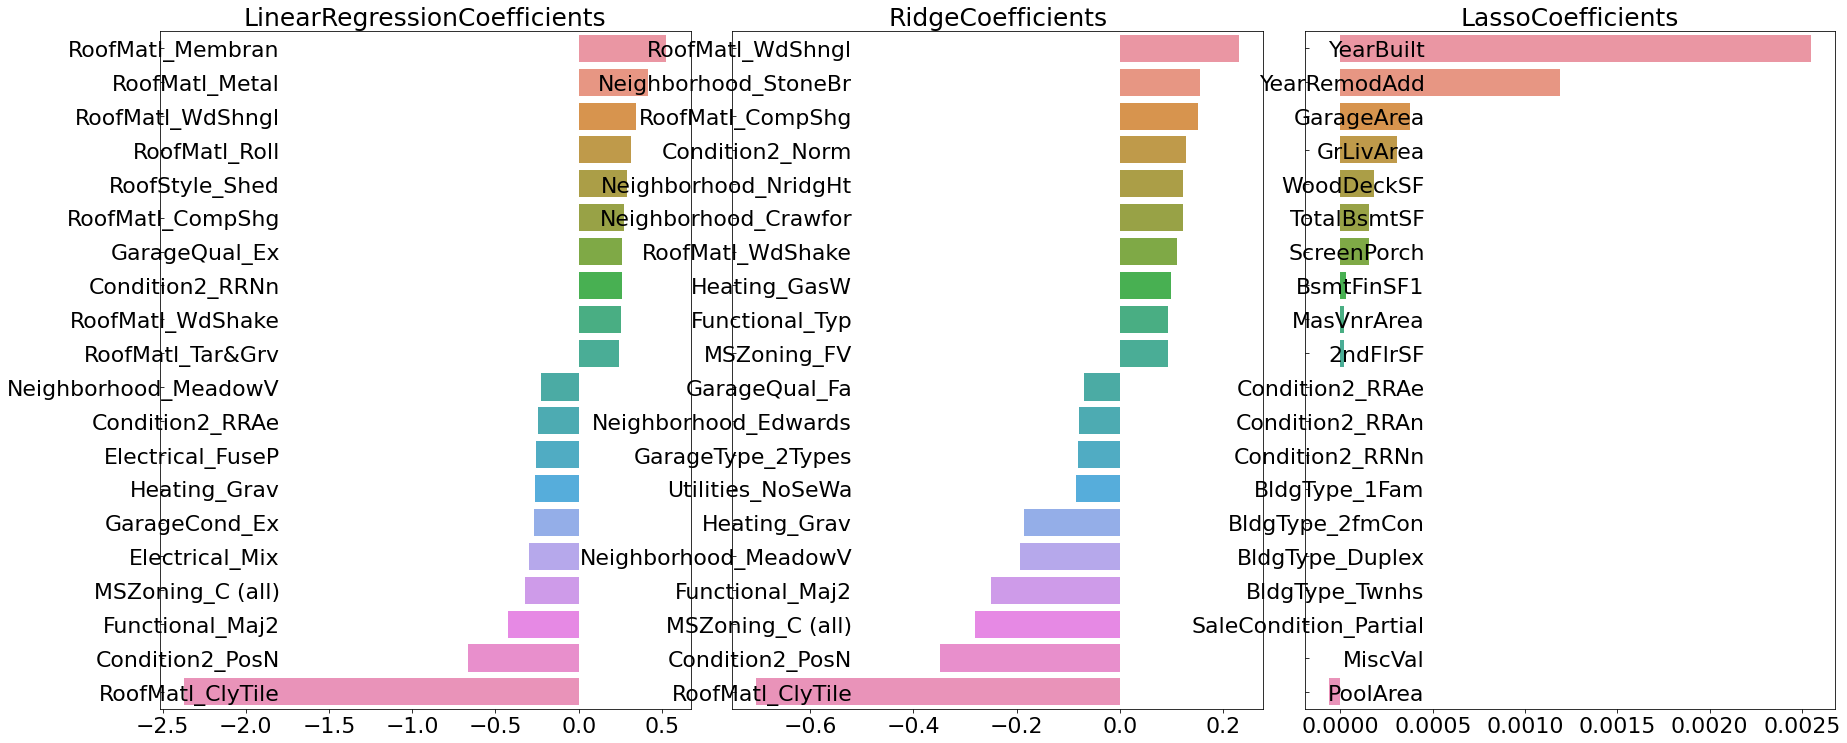

In [26]:
def visualize_coefficient(models):
  # 3개 회귀 모델의 시각화를 위해 3개의 칼럼을 가지는 subplot 생성
  fig, axs = plt.subplots(figsize = (24, 10), nrows = 1, ncols = 3)
  fig.tight_layout()
  # 입력인자로 받은 list 객체인 models에서 차례로 model을 추출하여 회귀 계수 시각화
  for i_num, model in enumerate(models):
    # 상위 10개, 하위 10개 회귀 계수를 구하고, 이를 판다스 concat으로 결합
    coef_high, coef_low = get_top_bottom_coef(model)
    coef_concat = pd.concat( [coef_high, coef_low] )
    # 순차적으로 ax subplot에 barchar로 표현, 한 화면에 표현하기 위해 tick label 위치와 font 크기 조정
    axs[i_num].set_title(model.__class__.__name__+'Coefficients', size = 25)
    axs[i_num].tick_params(axis = 'y', direction = 'in', pad = -120)
    for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
      label.set_fontsize(22)
    sns.barplot(x = coef_concat.values, y = coef_concat.index, ax = axs[i_num])

# 앞 예제에서 학습한 lr_reg, ridge_reg, lasso_reg 모델의 회귀 계수 시각화
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

In [27]:
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models):
  for model in models:
    # 분할하지 않고 전체 데이터로 cross_val_score() 수행. 모델별 CV RMSE값과 평균 RMSE 출력
    rmse_list = np.sqrt(-cross_val_score(model, X_features, y_target,
                                         scoring = 'neg_mean_squared_error', cv = 5))
    rmse_avg = np.mean(rmse_list)
    print('\n{0} CV RMSE 값 리스트: {1}'.format(model.__class__.__name__, np.round(rmse_list, 3)))
    print('{0} CV 평균 RMSE 값: {1}'.format(model.__class__.__name__, np.round(rmse_avg, 3)))

# 앞 예제에서 학습한 lr_reg, ridge_reg, lasso_reg 모델의 CV RMSE값 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_avg_rmse_cv(models)


LinearRegression CV RMSE 값 리스트: [0.135 0.165 0.168 0.111 0.198]
LinearRegression CV 평균 RMSE 값: 0.155

Ridge CV RMSE 값 리스트: [0.117 0.154 0.142 0.117 0.189]
Ridge CV 평균 RMSE 값: 0.144

Lasso CV RMSE 값 리스트: [0.161 0.204 0.177 0.181 0.265]
Lasso CV 평균 RMSE 값: 0.198


- 하이퍼 파리미터 튜닝

In [28]:
from sklearn.model_selection import GridSearchCV

def get_best_params(model, params):
  grid_model = GridSearchCV(model, param_grid = params,
                            scoring = 'neg_mean_squared_error', cv = 5)
  grid_model.fit(X_features, y_target)
  rmse = np.sqrt(-1 * grid_model.best_score_)
  print('{0} 5 CV 시 최적 평균 RMSE 값: {1}, 최적 alpha: {2}'.format(model.__class__.__name__,
                                                             np.round(rmse, 4), grid_model.best_params_))
  return grid_model.best_estimator_

ridge_params = {'alpha' : [0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha' : [0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1.5, 10]}
best_ridge = get_best_params(ridge_reg, ridge_params)
best_lasso = get_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값: 0.1418, 최적 alpha: {'alpha': 12}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.142, 최적 alpha: {'alpha': 0.001}


LinearRegression 로그 변환된 RMSE: 0.132
Ridge 로그 변환된 RMSE: 0.124
Lasso 로그 변환된 RMSE: 0.12


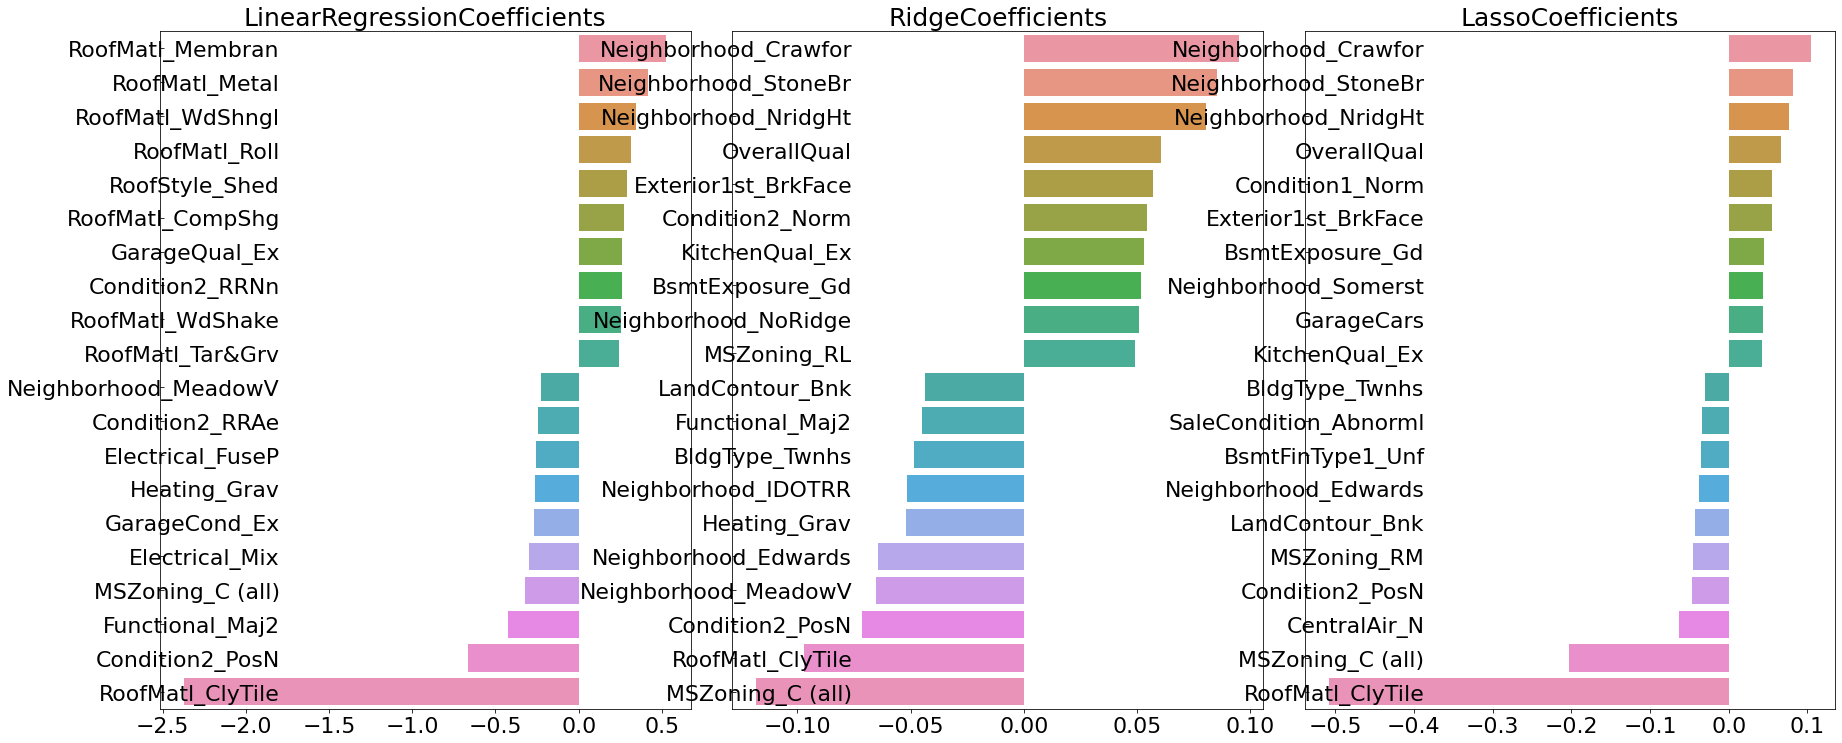

In [29]:
# 앞의 최적화 alpha 값으로 학습 데이터로 학습, 테스트 데이터로 예측 및 평가 수행
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha = 12)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha = 0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

- 데이터 왜곡 로그 변환 후 성능 평가

In [30]:
from scipy.stats import skew

# object가 아닌 숫자형 피처의 칼럼 index 객체 추출
features_index = house_df.dtypes[house_df.dtypes != 'object'].index
# house_df에 칼럼 index를 []로 입력하면 해당하는 칼럼 데이터 셋 반환
# apply lambda로 skew() 호출
skew_features = house_df[features_index].apply(lambda x : skew(x))
# skew 정도가 5 이상인 칼럼들만 추출
skew_features_top = skew_features[skew_features > 1]
print(skew_features_top.sort_values(ascending = False))

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.673661
LotFrontage       2.382499
OpenPorchSF       2.361912
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
dtype: float64


In [31]:
house_df[skew_features_top.index] = np.log1p(house_df[skew_features_top.index])

In [32]:
# Skew가 높은 피처들을 로그 변환 했으므로, 다시 원-핫 인코딩 적용 및 피처/타겟 데이터 셋 생성
house_df_ohe = pd.get_dummies(house_df)
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis = 1, inplace = False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size = 0.2, random_state = 156)

# 피처들을 로그 변환 후 다시 최적 하이퍼 파라미터와 RMSE 출력
ridge_params = { 'alpha' : [0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = { 'alpha' : [0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1.5, 10]}
best_ridge = get_best_params(ridge_reg, ridge_params)
best_lasso = get_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값: 0.1275, 최적 alpha: {'alpha': 10}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.1252, 최적 alpha: {'alpha': 0.001}


LinearRegression 로그 변환된 RMSE: 0.128
Ridge 로그 변환된 RMSE: 0.125
Lasso 로그 변환된 RMSE: 0.247


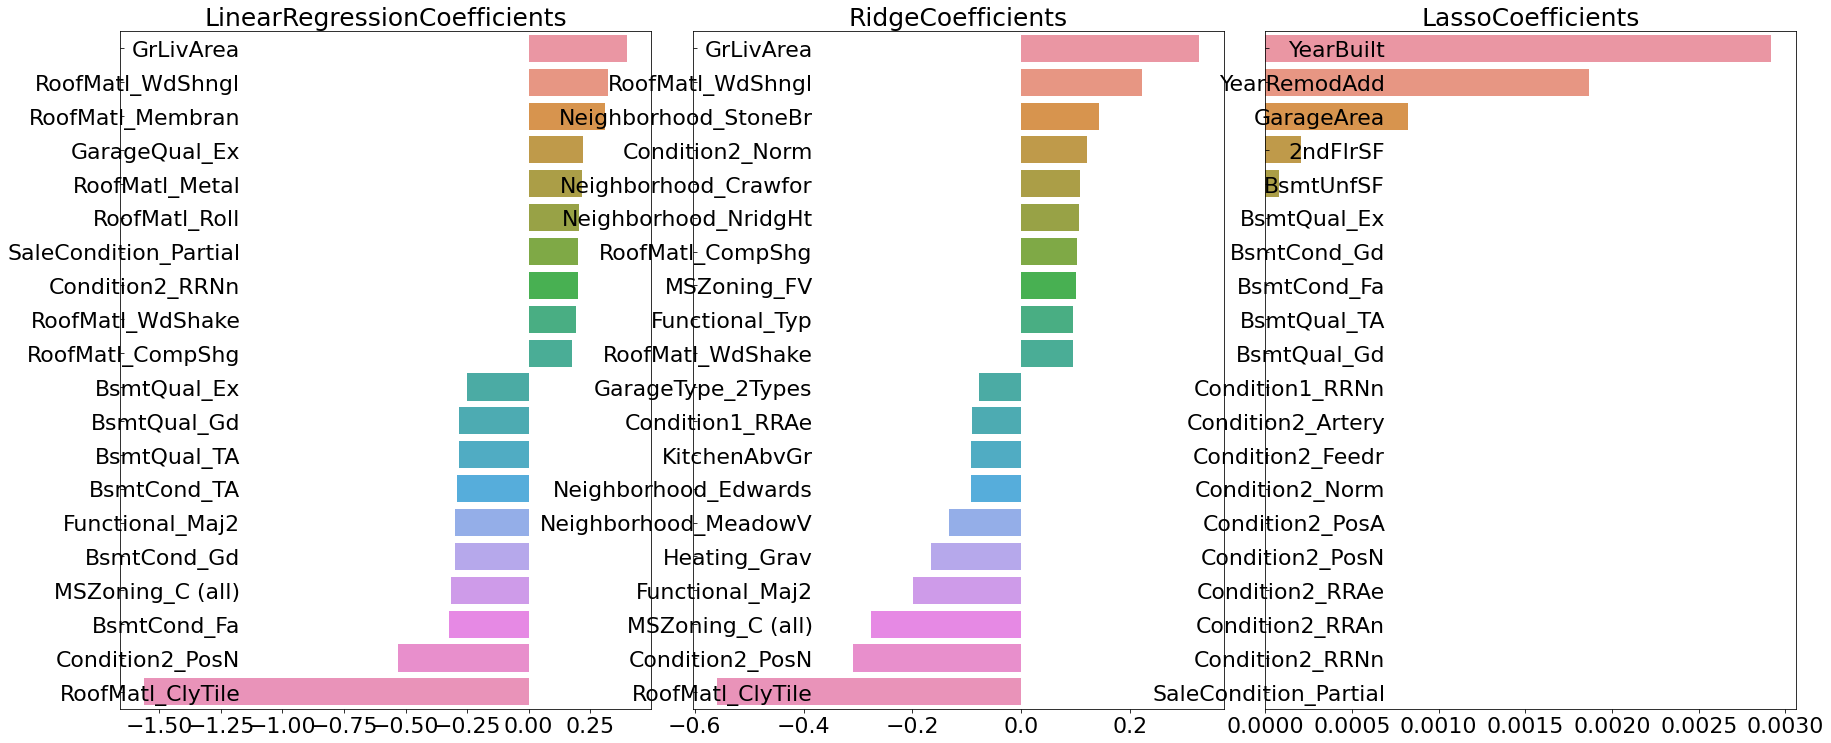

In [33]:
# 앞의 최적화 alpha 값으로 학습 데이터로 학습, 테스트 데이터로 예측 및 평가 수행
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

- 이상치 제거

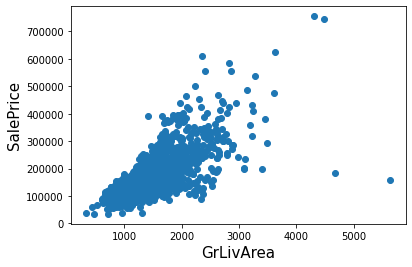

In [34]:
plt.scatter(x = house_df_org['GrLivArea'], y = house_df_org['SalePrice'])
plt.ylabel('SalePrice', fontsize = 15)
plt.xlabel('GrLivArea', fontsize = 15)
plt.show()

In [35]:
# GrLivArea와 SalePrice 모두 로그 변환되었으므로, 이를 반영한 조건 생성
cond1 = house_df_ohe['GrLivArea'] > np.log1p(4000)
cond2 = house_df_ohe['SalePrice'] < np.log1p(500000)
outlier_index = house_df_ohe[cond1 & cond2].index

print('아웃라이어 레코드 index:', outlier_index.values)
print('아웃라이어 삭제 전 house_df_ohe shape:', house_df_ohe.shape)
# DataFrame의 index를 이용하여 아웃라이어 레코드 삭제
house_df_ohe.drop(outlier_index, axis = 0, inplace = True)
print('아웃라이어 삭제 후 house_df_ohe shape:', house_df_ohe.shape)

아웃라이어 레코드 index: [ 523 1298]
아웃라이어 삭제 전 house_df_ohe shape: (1460, 271)
아웃라이어 삭제 후 house_df_ohe shape: (1458, 271)


In [36]:
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis = 1, inplace = False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size = 0.2, random_state = 156)

ridge_params = { 'alpha' : [0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = { 'alpha' : [0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1.5, 10]}
best_ridge = get_best_params(ridge_reg, ridge_params)
best_lasso = get_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값: 0.1125, 최적 alpha: {'alpha': 8}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.1122, 최적 alpha: {'alpha': 0.001}


LinearRegression 로그 변환된 RMSE: 0.129
Ridge 로그 변환된 RMSE: 0.103
Lasso 로그 변환된 RMSE: 0.1


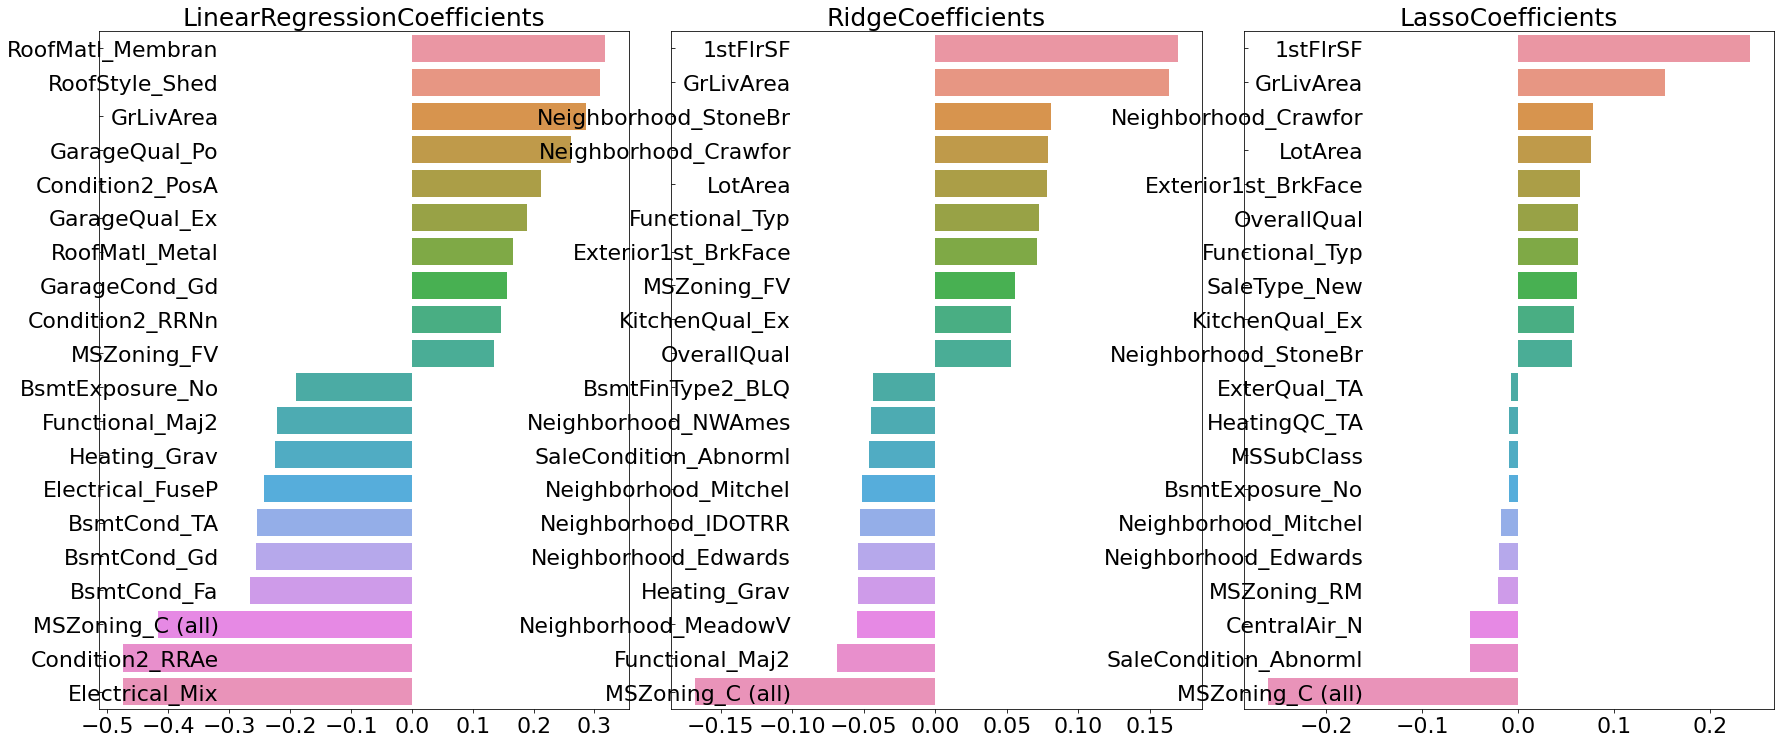

In [37]:
# 앞의 최적화 alpha 값으로 학습 데이터로 학습, 테스트 데이터로 예측 및 평가 수행
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha = 8)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha = 0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

#### **c. 회귀 트리 모델 학습/예측/평가**

In [38]:
from xgboost import XGBRegressor

xgb_params = {'n_estimators' : [1000]}
xgb_reg = XGBRegressor(n_estimators = 1000, learning_rate = 0.05,
                       colsample_bytree = 0.5, subsample = 0.8)
best_xgb = get_best_params(xgb_reg, xgb_params)

[05:15:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:15:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:15:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:15:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:16:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:16:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor 5 CV 시 최적 평균 RMSE 값: 0.115, 최적 alpha: {'n_estimators': 1000}


In [39]:
from lightgbm import LGBMRegressor

lgbm_params = {'n_estimators' : [1000]}
lgbm_reg = LGBMRegressor(n_estimators = 1000, learning_rate = 0.05, num_leaves = 4,
                         subsample = 0.6, colsample_bytree = 0.4, reg_lambda = 10, n_jobs = -1)
best_lgbm = get_best_params(lgbm_reg, lgbm_params)

LGBMRegressor 5 CV 시 최적 평균 RMSE 값: 0.1161, 최적 alpha: {'n_estimators': 1000}


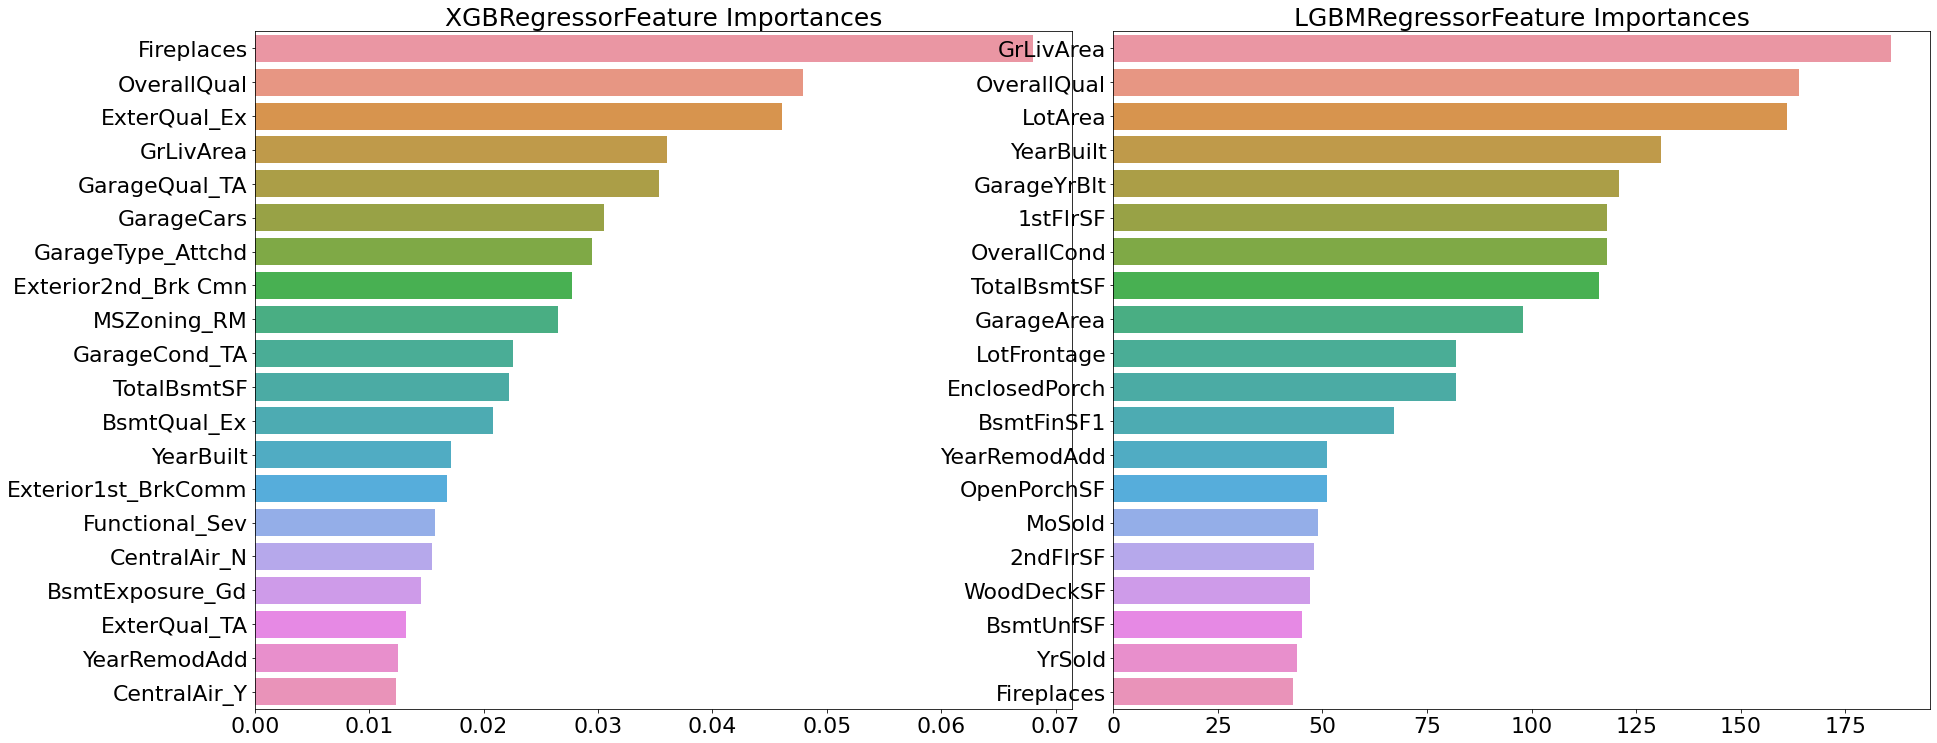

In [40]:
# 모델의 중요도 상위 20개의 피처명과 그때의 중요도값을 Series로 반환
def get_top_features(model):
  ftr_importances_values = model.feature_importances_
  ftr_importances = pd.Series(ftr_importances_values, index = X_features.columns)
  ftr_top20 = ftr_importances.sort_values(ascending = False)[:20]
  return ftr_top20

def visualize_ftr_importances(models):
  # 2개 회귀 모델의 시각화를 위해 2개의 칼럼을 가지는 subplot 생성
  fig, axs = plt.subplots(figsize = (24, 10), nrows = 1, ncols = 2)
  fig.tight_layout()
  # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 피처 중요도 시각화
  for i_num, model in enumerate(models):
    # 중요도 상위 20개의 피처명과 그때의 중요도값 추출
    ftr_top20 = get_top_features(model)
    axs[i_num].set_title(model.__class__.__name__+'Feature Importances', size = 25)
    # font 크기 조정
    for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
      label.set_fontsize(22)
    sns.barplot(x = ftr_top20.values, y = ftr_top20.index, ax = axs[i_num])

# 앞 예제에서 get_best_params()가 반환한 GridSearchCV로 최적화된 모델의 피처 중요도 시각화
models = [best_xgb, best_lgbm]
visualize_ftr_importances(models)

#### **d. 회귀 모델들의 예측 결과 혼합을 통한 최종 예측**

In [41]:
def get_rmse_pred(preds):
  for key in preds.keys():
    pred_value = preds[key]
    mse = mean_squared_error(y_test, pred_value)
    rmse = np.sqrt(mse)
    print('{0} 모델의 RMSE: {1}'.format(key, rmse))

# 개별 모델 학습
ridge_reg = Ridge(alpha = 8)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha = 0.001)
lasso_reg.fit(X_train, y_train)

# 개별 모델 예측
ridge_pred = ridge_reg.predict(X_test)
lasso_pred = lasso_reg.predict(X_test)

# 개별 모델 예측값 혼합으로 최종 예측값 도출
pred = 0.4 * ridge_pred + 0.6 * lasso_pred
preds = {'최종 혼합' : pred,
         'Ridge' : ridge_pred,
         'Lasso' : lasso_pred}

# 최종 혼합 모델. 개별모델의 RMSE 값 출력
get_rmse_pred(preds)

최종 혼합 모델의 RMSE: 0.10007930884470513
Ridge 모델의 RMSE: 0.10345177546603244
Lasso 모델의 RMSE: 0.10024170460890035


In [42]:
xgb_reg = XGBRegressor(n_estimators = 1000, learning_rate = 0.05,
                       colsample_bytree = 0.5, subsample = 0.8)
lgbm_reg = LGBMRegressor(n_estimators = 1000, learning_rate = 0.05, num_leaves = 4,
                         subsample = 0.6, colsample_bytree = 0.4, reg_lambda = 10, n_jobs = -1)
xgb_reg.fit(X_train, y_train)
lgbm_reg.fit(X_train, y_train)
xgb_pred = xgb_reg.predict(X_test)
lgbm_pred = lgbm_reg.predict(X_test)

pred = 0.5 * xgb_pred + 0.5 * lgbm_pred
preds = {'최종 혼합' : pred,
         'XGBM' : xgb_pred,
         'LGBM' : lgbm_pred}

get_rmse_pred(preds)

[05:16:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
최종 혼합 모델의 RMSE: 0.09897715854093486
XGBM 모델의 RMSE: 0.10075115846547565
LGBM 모델의 RMSE: 0.1015065721553885


#### **e. 스태킹 앙상블 모델을 통한 회귀 예측**

In [47]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):
  # 지정된 n_folds 값으로 KFold 생성
  kf = KFold(n_splits = n_folds, shuffle = False)
  # 추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화
  train_fold_pred = np.zeros((X_train_n.shape[0], 1))
  test_pred = np.zeros((X_test_n.shape[0], n_folds))
  print(model.__class__.__name__, 'model 시작')

  for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
    # 입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 세트 추출
    print('\t 폴드 세트: ', folder_counter, '시작')
    X_tr = X_train_n[train_index]
    y_tr = y_train_n[train_index]
    X_te = X_train_n[valid_index]

    # 폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행
    model.fit(X_tr, y_tr)
    # 폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장
    train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
    # 입력된 원본 테스트 데이터를 폴드 세트 내 학습된 기반 모델에서 예측 후 데이터 저장
    test_pred[:, folder_counter] = model.predict(X_test_n)

  # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성
  test_pred_mean = np.mean(test_pred, axis = 1).reshape(-1, 1)

  # train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
  return train_fold_pred, test_pred_mean

> 이제 get_stacking_base_datasets()를 모델별로 적용해 메타 모델이 사용할 학습 피처 데이터 세트와 테스트 피처 데이터 세트를 추출해보자. 적용할 개별 모델은 릿지, 라쏘, XGBoost, LightGBM의 총 4개이다.

In [48]:
# get_stacking_base_datasets()는 넘파이 ndarray를 인자로 사용하므로 DataFrame을 넘파이로 변환
X_train_n = X_train.values
X_test_n = X_test.values
y_train_n = y_train.values

# 각 개별 기반(Base) 모델이 생성한 학습용/테스트용 데이터 반환
ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg, X_train_n, y_train_n, X_test_n, 5)
lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg, X_train_n, y_train_n, X_test_n, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, X_train_n, y_train_n, X_test_n, 5)
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_reg, X_train_n, y_train_n, X_test_n, 5)

Ridge model 시작
	 폴드 세트:  0 시작
	 폴드 세트:  1 시작
	 폴드 세트:  2 시작
	 폴드 세트:  3 시작
	 폴드 세트:  4 시작
Lasso model 시작
	 폴드 세트:  0 시작
	 폴드 세트:  1 시작
	 폴드 세트:  2 시작
	 폴드 세트:  3 시작
	 폴드 세트:  4 시작
XGBRegressor model 시작
	 폴드 세트:  0 시작
[05:17:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	 폴드 세트:  1 시작
[05:17:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	 폴드 세트:  2 시작
[05:17:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	 폴드 세트:  3 시작
[05:17:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	 폴드 세트:  4 시작
[05:17:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
LGBMRegressor model 시작
	 폴드 세트:  0 시작
	 폴드 세트:  1 시작
	 폴드 세트:  2 시작
	 폴드 세트:  3 시작
	 폴드 

In [49]:
# 개별 모델이 반환한 학습 및 테스트용 데이터 세트를 스태킹 형태로 결합
Stack_final_X_train = np.concatenate((ridge_train, lasso_train, xgb_train, lgbm_train), axis = 1)
Stack_final_X_test = np.concatenate((ridge_test, lasso_test, xgb_test, lgbm_test), axis = 1)

# 최종 메타 모델은 라쏘 모델을 적용
meta_model_lasso = Lasso(alpha = 0.0005)

# 개별 모델 예측값을 기반으로 새롭게 만들어진 학습/테스트 데이터로 메타 모델 예측 및 RMSE 측정
meta_model_lasso.fit(Stack_final_X_train, y_train)
final = meta_model_lasso.predict(Stack_final_X_test)
mse = mean_squared_error(y_test, final)
rmse = np.sqrt(mse)
print('스태킹 회귀 모델의 최종 RMSE 값은:', rmse)

스태킹 회귀 모델의 최종 RMSE 값은: 0.09738961783055025
